## 感染症指定医療機関の逼迫状況の可視化と重症者搬送計画モデルの提案

### はじめに
- 背景：感染症指定医療機関は逼迫しており、重症者を受け入れるための十分な病床の確保が困難を極めている。  
　　　各地では、重症者を受け入れる病床の確保のために、軽症者をホテルや自宅等で療養させる対策が取られるようになってきた。　　　　　
- 課題：新型コロナウイルスの感染が拡大する今、同時多発的に発生する重症者をいかに早く感染症指定医療機関に搬送するかが重要になってくる。
- 目的：はじめに、新型コロナウイルス感染拡大による感染症指定医療機関の逼迫状況の可視化を行い、医療崩壊リスクの現状を理解する。      
　　　次に、軽症者全員をホテルや自宅等で療養させた場合における重症者を受け入れる病床確保の可否をシミュレーションにより判断する。     
  　　　最後に、重症者搬送計画モデルを提案し、迅速かつ効果的な搬送計画の作成を支援することを目指す。
   
### 新型コロナウイルス感染拡大による感染症指定医療機関の逼迫状況の可視化
- 目的:感染症指定医療機関の病床数と感染者数の関係を都道府県別に観察し、現在の医療崩壊リスクについて考察する。

- データ: 都道府県別病床数:SIGNATE COVID-19 Rules and Master data - 都道府県マスタ[1]    
    　　 　 都道府県別感染者数：「新型コロナウイルス対策ダッシュボード」より[2] 

2020-04-17 17:33 時点のデータを使用


,都道府県,感染者数,病床数,病床使用率(%)
1,東京都,2379,118,2016
2,大阪府,806,78,1033
3,千葉県,475,58,818
4,神奈川県,544,74,735
5,兵庫県,347,50,694
6,石川県,131,20,655
7,埼玉県,444,70,634
8,福岡県,382,66,578
9,京都府,175,38,460
10,福井県,90,20,450


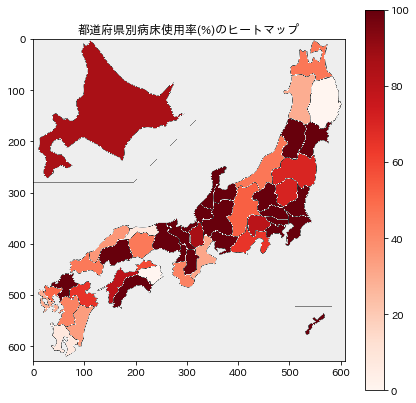

In [9]:
## import pandas as pd
import numpy as np
import pandas as pd
import datetime
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from japanmap import picture
%matplotlib inline

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),"時点のデータを使用")

# データ入手
df = pd.read_csv("https://www.stopcovid19.jp/data/covid19japan.csv")
df.columns = ["prefecture","都道府県","累積感染者数","感染者数","退院数","死亡数"]# 感染者数：現在の感染者数
df = df.merge(pd.read_csv("../data/SIGNATE COVID-19 Rules and Master data - 都道府県マスタ.csv",encoding="shift-jis"))
df["病床使用率(%)"] = (100*(df["感染者数"]/df["病床数"])).astype(int)

#  都道府県別病床使用率(%)のヒートマップによる可視化
plt.figure(figsize=(7,7))
plt.title("都道府県別病床使用率(%)のヒートマップ")
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=0, vmax=100)
fcol = lambda x: '#' + bytes(cmap(np.log1p(norm(x)), bytes=True)[:3]).hex()
plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
plt.imshow(picture(pd.Series(data=df["病床使用率(%)"].values,index=df["都道府県"]).apply(fcol)))

# 病床使用率(%)一覧
def multi_table(table_list):# テーブルを並べる
    return display(HTML('<table><tr style="background-color:white;">' +
                ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +'</tr></table>'))

def over_100(val):
    color = 'red' if val >= 100 else 'black'
    return 'color: %s' % color
    

rank_df = df[["都道府県","感染者数","病床数","病床使用率(%)"]].sort_values("病床使用率(%)",ascending=False).reset_index(drop=True)
rank_df.index+=1
multi_table([(rank_df.loc[1+i:10+i,:].style.applymap(over_100,subset=["病床使用率(%)"])) for i in range(0,50,10)])

**結果**
- 病床使用率（感染者数 / 病床数）は、27都道府県で100％を超えていた。

**考察**
- 感染者が全員入院しなければならなくなった場合、少なくとも27都府県では医療機関の対応能力を超えてしまう問題がある。
- 既に医療機関の対応能力を越えており、感染症以外の対応も含め医療システムが崩壊してもおかしくない状況下にある。     
- **軽症者をホテルや自宅等で療養させた場合でも、重症者を受け入れる病床の確保されているかが怪しいほど逼迫している。**

### 重症者を受け入れる病床確保の可否判断のためのシミュレーション

**シミュレーション概要**
- 中国の実データ分析事例[3]によると、感染者数(4万4672人)のうち軽症が約81％(3万6160人)、重症が約19％(8255人)であったとの報告があった。
- この事例に基づき、国内の感染者のうちランダムに選ばれた19％が重症者とした場合の都道府県別病床使用率を計算する。
- 上記計算を乱数を変えて1000回行い、その病床使用率の平均値と最大値を評価する。

,都道府県,mean,std,max,min
1,北海道,25.070000,4.669382,37.000000,15.000000
2,青森県,10.440000,5.384827,27.000000,3.000000
3,岩手県,0.000000,0.000000,0.000000,0.000000
4,宮城県,39.140000,11.166346,75.000000,13.000000
5,秋田県,6.180000,3.712877,21.000000,0.000000
6,山形県,50.320000,12.478572,72.000000,11.000000
7,福島県,19.420000,6.242863,36.000000,5.000000
8,茨城県,39.980000,7.711961,58.000000,18.000000
9,栃木県,19.110000,7.591722,48.000000,3.000000
10,群馬県,34.700000,7.217403,51.000000,17.000000


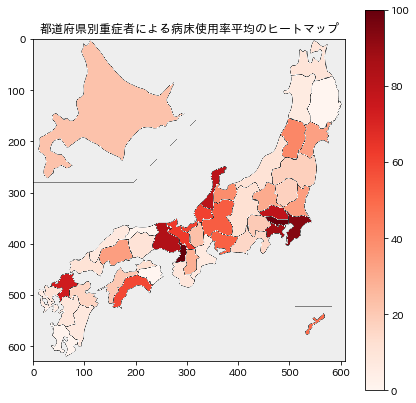

In [10]:
# シミュレーション 
import random
x,sim = [],[]
[x.extend(df["都道府県"][i] for j in range(df["感染者数"][i])) for i in range(len(df))]
for r in range(100):
    random.seed(r)
    sim_df = pd.Series(random.sample(x,int(0.19*len(x)))).value_counts()
    sim_df = pd.DataFrame({"都道府県":sim_df.index,"重傷者数":sim_df.values})
    sim_df = pd.merge(df,sim_df,on="都道府県",how="outer").fillna(0)
    sim.append((100*sim_df["重傷者数"]/sim_df["病床数"]).astype(int))

# 結果集計
sim_df = pd.concat([sim_df[["都道府県"]],pd.concat(sim,axis=1).T.describe().T[["mean","std","max","min"]]],axis=1)
sim_df.index+=1
multi_table([sim_df.loc[1+i:24+i,:].style.applymap(over_100,subset=["mean","max"]) for i in range(0,48,24)])

#  都道府県別病床使用率(%)のヒートマップによる可視化
plt.figure(figsize=(7,7))
plt.title("都道府県別重症者による病床使用率平均のヒートマップ")
cmap = plt.get_cmap('Reds')
norm = plt.Normalize(vmin=0, vmax=100)
fcol = lambda x: '#' + bytes(cmap(np.log1p(norm(x)), bytes=True)[:3]).hex()
plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
plt.imshow(picture(pd.Series(data=sim_df["mean"].values,index=sim_df["都道府県"]).apply(fcol)))

**結果**
- 8都府県で重症者による病床使用率の平均が100％を超える結果となった。
- 13都府県で重症者による病床使用率の最大値が100％を超える結果となった。

**考察**
- **シミュレーションの結果、軽症者全員をホテルや自宅等で療養させた場合における重症者を受け入れる病床の確保は都道府県によっては難しいということが明らかになった。**
- **将来、県境を越えて受け入れ可能な医療機関を使用しなければならない状況が起こる可能性が示唆された。**

### 問題設定

**目標**
- 重症者全員をいずれかの感染症指定医療機関へ割り当てる問題として定式化を行う。

**定式化**
- 各医療機関の病床数上限を満たし，重症者全員の総搬送距離をできるだけ少なくなるように割り当てる問題を考える。
- 以下のように定式化した。
    - 重症者$ i(\in I)$に医療機関$ j(\in J)$を搬送する。
    - 重症者$i$が医療機関$j$に移動する時の距離は$d_{ij}$である。
    - 重症者$i$を医療機関$j$に割り当てる場合、$x_{ij}=1$、そうでない場合を$x_{ij}=0$とする。
    - 総搬送距離が最小となるような$x_{ij}$を求める。
    - 医療機関$j$の病床数$C_j$の上限を超えないものとする。
    - 重症者全員がいずれかの医療機関$j$に搬送される。
   
$$
\begin{aligned}
\text{minimize}\quad & \sum _ {i \in I}\sum _ {j\in J} d _ {ij} x _ {ij} \\
\text{subject to}\quad & \sum _{i\in I} x _ {ij} \le C_j \\
                          & \sum _ {j\in J} x _ {ij} = 1\\
                          & \forall x _ {ij } \in \{0,1\}
\end{aligned}
$$

### 数値実験

**目標**
- 実際の感染者数データと医療機関データを用いて簡易的な数値実験例を示す。

**データ**
- 都道府県別感染者数：「新型コロナウイルス対策ダッシュボード」より
- 都道府県別重症者数：都道府県別感染者数のうちランダムに選ばれた19％を重症者とする。
- 「SIGNATE COVID-2019 Dataset」のシート「都道府県マスタ」の緯度経度情報・病床数

**定義**
- 医療機関毎の病床数の内訳・位置情報がないため、医療機関$i$は各都道府県の県庁所在地に１つだけ存在するものとする。     
- 重症者ごとの位置情報がないため、重症者$j$の位置情報は所在する都道府県の県庁所在地とする。。 
- 搬送距離$d_{ij}$は２点間緯度経度情報を用いたVincenty法により求める。

In [11]:
## 緯度経度から2地点間の距離と方位角を計算する　参考URL　https://qiita.com/r-fuji/items/99ca549b963cedc106ab

from math import *

# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体ごとの長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(逆解法)
2地点の座標(緯度経度)から、距離と方位角を計算する
:param lat1: 始点の緯度
:param lon1: 始点の経度
:param lat2: 終点の緯度
:param lon2: 終点の経度
:param ellipsoid: 楕円体
:return: 距離と方位角
'''
def vincenty_inverse(lat1, lon1, lat2, lon2, ellipsoid=None):

    # 差異が無ければ0.0を返す
    if isclose(lat1, lat2) and isclose(lon1, lon2):
        return 0

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_GRS80))
    b = (1 - ƒ) * a

    φ1,φ2, λ1,λ2= radians(lat1),radians(lat2),radians(lon1),radians(lon2)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))
    U2 = atan((1 - ƒ) * tan(φ2))

    sinU1,sinU2,cosU1,cosU2 = sin(U1),sin(U2),cos(U1), cos(U2)

    # 2点間の経度差
    L = λ2 - λ1

    # λをLで初期化
    λ = L

    # 以下の計算をλが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        sinλ,cosλ = sin(λ),cos(λ)
        sinσ = sqrt((cosU2 * sinλ) ** 2 + (cosU1 * sinU2 - sinU1 * cosU2 * cosλ) ** 2)
        cosσ = sinU1 * sinU2 + cosU1 * cosU2 * cosλ
        σ = atan2(sinσ, cosσ)
        sinα = cosU1 * cosU2 * sinλ / sinσ
        cos2α = 1 - sinα ** 2
        cos2σm = cosσ - 2 * sinU1 * sinU2 / cos2α
        C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
        λʹ = λ
        λ = L + (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))

        # 偏差が.000000000001以下ならbreak
        if abs(λ - λʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # λが所望の精度まで収束したら以下の計算を行う
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))
    Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))

    # 2点間の楕円体上の距離
    s = b * A * (σ - Δσ)

    # 各点における方位角
    α1 = atan2(cosU2 * sinλ, cosU1 * sinU2 - sinU1 * cosU2 * cosλ)
    α2 = atan2(cosU1 * sinλ, -sinU1 * cosU2 + cosU1 * sinU2 * cosλ) + pi

    if α1 < 0:
        α1 = α1 + pi * 2

    return int(s/1000)# km

In [12]:
# 重症者　発生
import random
random.seed(2020)
x,sim = [],[]
[x.extend(df["都道府県"][i] for j in range(df["感染者数"][i])) for i in range(len(df))]
data = pd.Series(random.sample(x,int(0.19*len(x))))

# 重症者数　集計
sim_df = data.value_counts()
sim_df = pd.DataFrame({"都道府県":sim_df.index,"重症者数":sim_df.values})
sim_df = pd.merge(df,sim_df,on="都道府県",how="outer").fillna(0)
sim_df = sim_df[["都道府県","緯度（世界測地系）","経度（世界測地系）","病床数","重症者数"]]
sim_df["病床使用率(%)"] = (100*(sim_df["重症者数"]/sim_df["病床数"])).astype(int)

# 重症者データ　モデル用
data = pd.DataFrame({"id":data.index,"都道府県":data.values})
data = pd.merge(data,df[["都道府県","病床数","緯度（世界測地系）","経度（世界測地系）"]],on="都道府県",how="left").fillna(0)
data["搬送先"],data["搬送距離"] = "j",0

## 数値実験
from pulp import *
import pydot
from itertools import product

# 重症者　I　医療機関　J 
I,J = data.id.tolist(), sim_df["都道府県"].tolist()

# 医療機関$j$の病床数 C_j
capacities = sim_df["病床数"].tolist()

# 移動距離(d_ij)行列 
D,a= [],[]
for i,j in product(I,J):
    d = vincenty_inverse(data["緯度（世界測地系）"][i], data["経度（世界測地系）"][i],
                         sim_df.query("都道府県==@j")["緯度（世界測地系）"], sim_df.query("都道府県==@j")["経度（世界測地系）"], ellipsoid=None)
    D.append([(i,j),d])
    a.append([(data["都道府県"][i],j),d])
D = dict(D)

In [13]:
%%time
## 数理モデル
model = LpProblem("Transportation", LpMinimize)

# 決定変数　搬送人数　x_ij
x = {(i,j): LpVariable("x{}-{}".format(i,j),cat = LpBinary) for i in I for j in J}


# 目的関数 
model += lpSum([D[i,j] * x[i,j] for i in I for j in J]), "Objective"

# 制約
for j, Cj in enumerate(capacities):
    j = J[j]
    model += lpSum([x[i,j] for i in range(len(I))]) <= Cj, "Capacity{}".format(j)

for i in I:
    model += lpSum([x[i,j] for j in J]) == 1, "Patient{}".format(i)
    
model.solve()
y = value(model.objective)
print("総搬送距離 = {0} km".format(y))

総搬送距離 = 96243.0 km
CPU times: user 2.21 s, sys: 60.9 ms, total: 2.27 s
Wall time: 4.89 s


,都道府県,最適化前,最適化後
1,東京都,389,100
2,大阪府,210,100
3,石川県,150,100
4,神奈川県,141,100
5,千葉県,131,100
6,福岡県,130,100
7,兵庫県,124,100
8,埼玉県,108,100
9,福井県,90,100
10,高知県,90,90


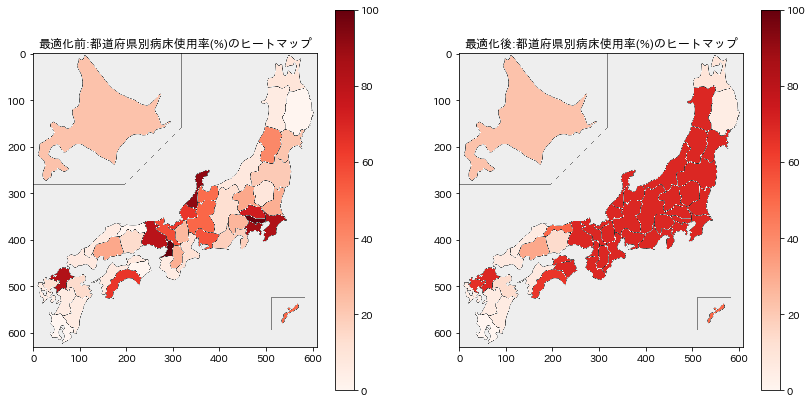

In [15]:
#集計
data["搬送先"] = [str(xij).split("_")[1] for xij in x.values() if xij.varValue==1]
data["搬送距離"] = [D[i,data["搬送先"][i]] for i in I]
res = pd.concat([data[c].value_counts() for c in ["都道府県","搬送先"]],axis=1).reset_index()
res = res.rename(columns={"index":"都道府県","都道府県":"最適化前","搬送先":"最適化後"})
res = (pd.merge(res,sim_df[["都道府県","病床数"]],how="outer").fillna(0))
res["最適化前"],res["最適化後"] = (100*res["最適化前"]/res["病床数"]).astype(int), (100*res["最適化後"]/res["病床数"]).astype(int)
res = res.sort_values("最適化前",ascending=False).reset_index(drop=True)
res.index+=1
multi_table([res.loc[1+i:10+i,res.columns[:3]].style.applymap(over_100,subset=res.columns[1:3]) for i in range(0,48,10)])

#  都道府県別病床使用率(%)のヒートマップ比較
fig = plt.figure(figsize=(14,7))

for i,j in enumerate(["最適化前","最適化後"]):
    ax = fig.add_subplot(1, 2, i+1)
    plt.title(j+":都道府県別病床使用率(%)のヒートマップ")
    cmap = plt.get_cmap('Reds')
    norm = plt.Normalize(vmin=0, vmax=100)
    fcol = lambda x: '#' + bytes(cmap(np.log1p(norm(x)), bytes=True)[:3]).hex()
    plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
    ax.imshow(picture(pd.Series(data=res[j].values,index=res["都道府県"]).apply(fcol)))

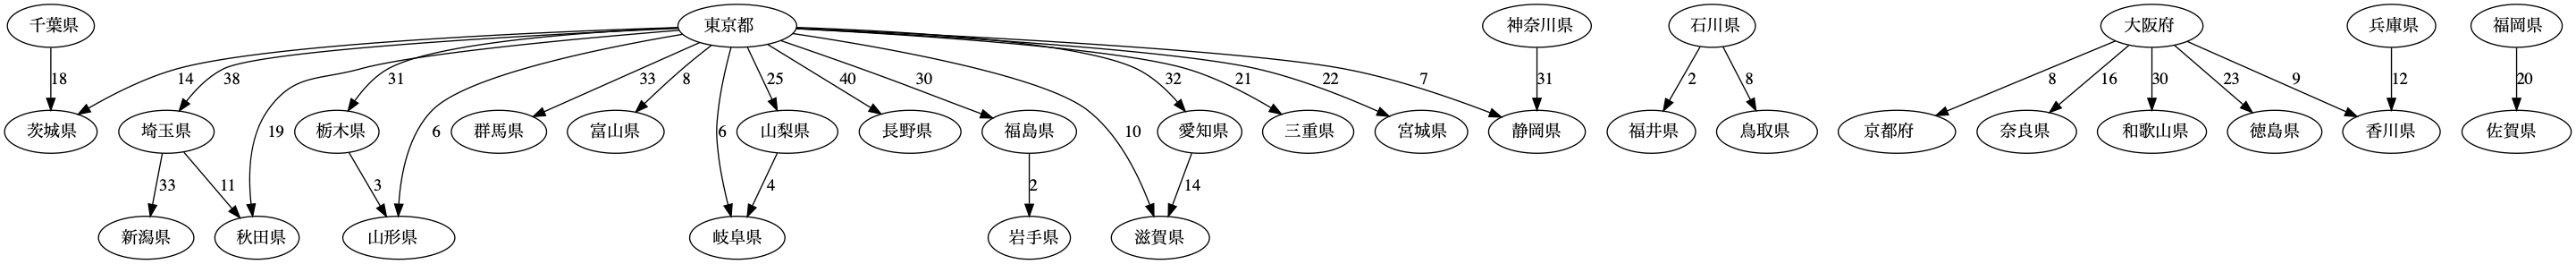

In [16]:
# 他の都道府県への遷移図の可視化　
from IPython.display import Image
def create_graph(df):
    graph = pydot.Dot(graph_type='digraph')

    # ノードを追加
    df = df - np.diag(np.diag(df))
    for col in df.columns[np.logical_or(df.max(axis=0)>0,df.max(axis=1)>0)]:
        node = pydot.Node(f'"{col}"', label=col)
        graph.add_node(node)

    # エッジを追加
    for i, j in product(df.columns, repeat=2):
        val = df.loc[i, j]
        # 相関係数の絶対値が threshold 未満の場合はエッジを追加しない
        
        if abs(val) <= 0 :
            continue
        edge = pydot.Edge(graph.get_node(f'"{i}"')[0], graph.get_node(f'"{j}"')[0])
        edge.set_label(f'{val:.0f}')
        graph.add_edge(edge)

    return graph

network = pd.DataFrame(columns=sim_df["都道府県"].values,index=sim_df["都道府県"].values,data=0)
for i in data[["都道府県","搬送先"]][data["都道府県"]!=data["搬送先"]].index:
    network.loc[data["都道府県"][i],data["搬送先"][i]] += 1
graph = create_graph(network)
display(Image(graph.create(format='png')))

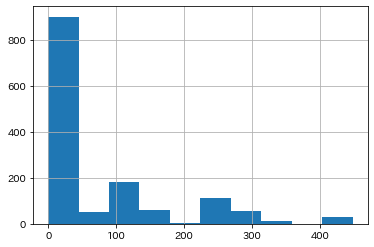

In [17]:
# 個人の搬送距離に着目した場合
d = data["搬送距離"].value_counts()
d = pd.DataFrame({"移動距離":d.index,"重症者数":d.values})
d = d.sort_values("移動距離").reset_index(drop=True)
multi_table([pd.DataFrame(data["搬送距離"].describe()),d.head(),d.tail()])
data["搬送距離"].hist()

**結果**
- 各都道府県にいる重症者全員をいずれかの感染症指定医療機関へ割り当てることに成功した。
- 計算時間は約5秒、総搬送距離は約96243km、1人あたりの平均搬送距離は約68kmとなった。
- 29の都道府県で病床使用率が100％になった。
- 総搬送距離を最小化させようとすると、埼玉県・栃木県・山梨県・福島県・愛知県のように他都道府県を受け入れを優先してしまうパターンがあることがわかった。
- 搬送距離が0の重症者が817人いる一方で448km搬送される重症者も19人いる。

**考察**
- 1人あたりの平均移動距離が約68km（東京⇄横須賀間くらい）となっており、搬送における感染リスクが低いとは言えない。
- 今回は100%になるまで受け入れる設定にしたが、今後の感染者増加を考慮して上限を決めるなどの対策も必要になってくる。
- **軽症者全員をホテルや自宅等で療養させた場合でも、重症者を受け入れる病床確保は極めて厳しい状況であることがわかった。**

## おわりに

**貢献**
- 都道府県別病床使用率の分析とその考察を行った。
- 重症者を受け入れる病床確保の可否判断のためのシミュレーションを行い、医療崩壊リスクについて議論した。
- 各医療機関の病床数上限を満たし，重症者全員の総搬送距離をできるだけ少なくなるように割り当てる数理モデルを定式化した。
- 数理モデルを実装し、結果の可視化とその考察を行った。

**課題**
- 感染者及び医療機関の位置情報の精緻化とそれに伴う数理モデルの改良
- 動的な搬送計画としての数理モデル化。
- **一人ひとりの予防意識**

**最後に**
- 正直、私は分析をするまでそこまで新型コロナウイルスに対してどこか他人事のように捉えていました。     
  実際に手を動かしたからこそ自分事化して考えることができたのではないかと思います。     
  流石に重症で448kmも搬送されたくはないです。
- 今回の分析は、「社会距離戦略の意思決定に資する」程大それたものでは決してありません。     
  ただ、いろんな意味で「少なくとも議論の題材になる」分析をすることはできてのではないかと思っています。     
- ここまで読んでくださり本当にありがとうございました。感想・助言等ありましたら是非コメントしていただけると幸いです。

### 参考URL
[1]  https://bit.ly/signate_covid-19_dataset      
[2]  https://www.stopcovid19.jp/data/covid19japan.csv     
[3]  The Novel Coronavirus Pneumonia Emergency Response Epidemiology Team (2020) "Vital surveillances: The epidemiological characteristics of an outbreak of 2019 novel coronavirus diseases (COVID-19) - China, 2020," China CDC weekly, 2020.